In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt


In [3]:
ls

CFRC_Amazon-Copy1.ipynb  __pycache__/             model01.h5
CFRC_Amazon.ipynb        bookDataset/             movies_history.pkl
CFRC_Books-2.ipynb       books_history.pkl        movies_history_1.pkl
CFRC_Books.ipynb         books_history_1.pkl      movies_history_2.pkl
CFRC_BooksF.ipynb        books_history_2.pkl      movies_logs/
CFRC_Movies.ipynb        books_logs/              prepdata.py
CFRC_MoviesF.ipynb       makeRec.py               ratings_Electronics.csv
ExploringData.ipynb      ml-latest-small/         recmodel.py


# First, load the data and apply preprocessing

In [ ]:
The following function loads data into Dataframe with 

In [4]:
from prepdata import load

In [5]:
import os
#book dir holds both ratings.csv and books.csv
books_dir= os.path.abspath(os.path.abspath("bookDataset"))
amazon_file = os.path.abspath(os.path.abspath("ratings_Electronics.csv"))
#movie dir holds both  ratings.csv and movies.csv
movies_dir = os.path.abspath(os.path.abspath("ml-latest-small"))

We will be testing on the Book Dataset: 
   - itemId represents "book id" 

In [6]:
df, books_df = load("books", books_dir)

In [7]:
df

,itemId,userId,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4
...,...,...,...
981751,10000,48386,5
981752,10000,49007,4
981753,10000,49383,5
981754,10000,50124,5


In [8]:
from prepdata import createList, formatData

In [9]:
user = createList(df, pram= 'user')
item = createList(df, pram= 'item')

In [10]:
num_users, num_items = formatData(df, user,item)

Number of users: 53424, Number of Books: 10000, Min rating: 1.0, Max rating: 5.0


In [11]:
df

,itemId,userId,rating,user,item
0,1,314,5.0,0,0
1,1,439,3.0,1,0
2,1,588,5.0,2,0
3,1,1169,4.0,3,0
4,1,1185,4.0,4,0
...,...,...,...,...,...
981751,10000,48386,5.0,9166,9999
981752,10000,49007,4.0,28415,9999
981753,10000,49383,5.0,31031,9999
981754,10000,50124,5.0,16722,9999


# Prepare training and validation data

In here, we shuffle the data indices and made a 90/10 split for test/val. 

In [12]:
from prepdata import prepData

In [13]:
x_train, x_val, y_train, y_val = prepData(df)

# Create the model

We embed both users and movies in to 50-dimensional vectors.

The model computes a match score between user and movie embeddings via a dot product, and adds a per-movie and per-user bias. The match score is scaled to the [0, 1] interval via a sigmoid (since our ratings are normalized to this range).

In [14]:
EMBEDDING_SIZE = 50


class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


model = RecommenderNet(num_users, num_items, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001)
)


Metal device set to: Apple M1 Pro


2022-05-06 11:02:44.021229: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-06 11:02:44.021678: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/citlallylopez/miniforge3/envs/mbp/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


# Train the model based on the data split

In [22]:
#saving checkoints
from keras.callbacks import ModelCheckpoint

#issue: unable to use due to subclassed model
checkpoint = ModelCheckpoint('books_logs/model{epoch:02d}.h5', monitor='loss', verbose=1,
     save_best_only=True, mode='auto', save_freq='epoch', save_weights_only=True)

In [50]:
%time
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=10,
    verbose=1,
    validation_data=(x_val, y_val),
    callbacks=[checkpoint]
)



CPU times: user 4 µs, sys: 3 µs, total: 7 µs
Wall time: 13.1 µs
Epoch 1/10
13805/13806 [============================>.] - ETA: 0s - loss: 1.1506
Epoch 1: loss improved from inf to 1.15070, saving model to books_logs/model01.h5
13806/13806 [==============================] - 221s 16ms/step - loss: 1.1507 - val_loss: 0.9434
Epoch 2/10
13804/13806 [============================>.] - ETA: 0s - loss: 1.1871
Epoch 2: loss did not improve from 1.15070
13806/13806 [==============================] - 223s 16ms/step - loss: 1.1870 - val_loss: 0.9737
Epoch 3/10
13806/13806 [==============================] - ETA: 0s - loss: 1.3166
Epoch 3: loss did not improve from 1.15070
13806/13806 [==============================] - 221s 16ms/step - loss: 1.3166 - val_loss: 1.0626
Epoch 4/10
13803/13806 [============================>.] - ETA: 0s - loss: 1.3079
Epoch 4: loss did not improve from 1.15070
13806/13806 [==============================] - 221s 16ms/step - loss: 1.3078 - val_loss: 0.9899
Epoch 5/10
13805/

### Load and save history

In [15]:
import pickle
# Save train  loss history - changes previous history if trained before
pickle.dump(history, open('books_history_2.pkl', 'wb'))

INFO:tensorflow:Assets written to: ram://18e122f8-a00d-452c-83b8-f5a70c120088/assets


In [40]:
#if training before, input old history
with open('books_history.pkl', 'rb') as f:
    h = pickle.load(f)

In [63]:
h.history

{'loss': [0.6069590449333191,
  0.6254448890686035,
  0.6838517785072327,
  0.74885094165802,
  0.8136065006256104],
 'val_loss': [0.6028047800064087,
  0.6430683732032776,
  0.681881308555603,
  0.7193261384963989,
  0.7446820735931396]}

### Load and save model

In [16]:
from recmodel import get_latestfile

In [17]:
books_log= os.path.abspath(os.path.abspath("books_logs"))

In [18]:
os.chdir(books_log)

In [19]:
latest=get_latestfile(os.listdir())
latest

'model10.h5'

In [21]:
# load model
from keras.models import load_model
weights = load_model(latest)

ValueError: No model config found in the file at <tensorflow.python.platform.gfile.GFile object at 0x2acffae50>.

In [20]:
model.load_weights(latest)

ValueError: Unable to load weights saved in HDF5 format into a subclassed Model which has not created its variables yet. Call the Model first, then load the weights.

# Plot training and validation loss

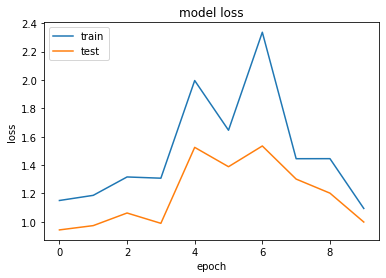

In [52]:
#third attempt with 10 epochs --"books_history_2.pkl"
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()


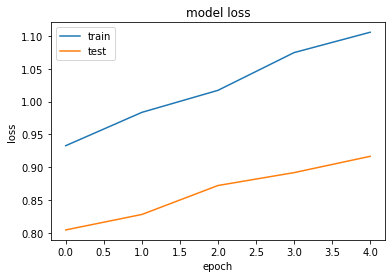

In [47]:
#second attempt with 5 epochs --"books_history_1.pkl"
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()


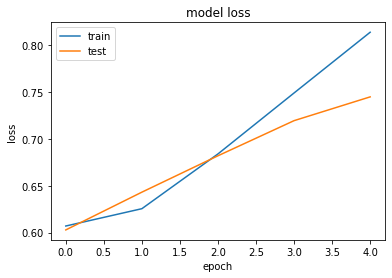

In [46]:
#first attempt with 5 epochs --"books_history.pkl"
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()


# Show top 10 book recommendations to a user

We were are to predict 10 book recommendations. However, the code below was used before modifiying datasets. Needs to be revised. Currently working on revising function under makeRec module

In [52]:
# Let us get a user and see the top recommendations.
uid = df.user_id.sample(1).iloc[0]
items_by_user = df[df.user_id == uid]
items_not_watched = items_df[
    ~items_df["book_id"].isin(items_by_user.book_id.values)
]["book_id"]
items_not_watched = list(
    set(items_not_watched).intersection(set(item2item_encoded.keys()))
)
items_not_watched = [[item2item_encoded.get(x)] for x in items_not_watched]
user_encoder = user2user_encoded.get(uid)
user_item_array = np.hstack(
    ([[user_encoder]] * len(items_not_watched), items_not_watched)
)
ratings = model.predict(user_item_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_item_ids = [
    item_encoded2item.get(items_not_watched[x][0]) for x in top_ratings_indices
]


In [56]:
print("Showing recommendations for user: {}".format(uid))
print("====" * 9)
print("Books with high ratings from user")
print("----" * 8)
top_item_user = (
    items_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .book_id.values
)
items_df_rows = items_df[items_df["book_id"].isin(top_item_user)]
for row in items_df_rows.itertuples():
    print(row.original_title, "by", row.authors)

print("----" * 8)
print("Top 10 book recommendations")
print("----" * 8)
recommended_items = items_df[items_df["book_id"].isin(recommended_item_ids)]
for row in recommended_items.itertuples():
    print(row.original_title, "by", row.authors)

Showing recommendations for user: 20264
Books with high ratings from user
--------------------------------
Girl with a Pearl Earring by Tracy Chevalier
--------------------------------
Top 10 book recommendations
--------------------------------
Animal Farm: A Fairy Story by George Orwell
Jurassic Park by Michael Crichton
El amor en los tiempos del cólera by Gabriel García Márquez, Edith Grossman
The Andromeda Strain by Michael Crichton
Timeline by Michael Crichton
Sherlock Holmes: The Complete Novels and Stories, Vol 2 by Arthur Conan Doyle, Kyle Freeman
Next by Michael Crichton
Ὀρέστεια by Aeschylus, Robert Fagles, William Bedell Stanford
The Terminal Man by Michael Crichton
Cradle to Cradle: Remaking the Way We Make Things by William McDonough, Michael Braungart
